In [1]:
# Cell 1 — Imports & paths (TF 2.12)
import os, random, math, json, shutil
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
import cv2

print(tf.__version__)

# repo structure (adjust if different)
ROOT = Path.cwd().parent  # if notebook is in notebooks/, parent is repo root
processed_root = ROOT / "data_processed"
models_dir = ROOT / "models"
models_dir.mkdir(exist_ok=True)
augment_samples_dir = models_dir / "augment_samples"
augment_samples_dir.mkdir(exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 32  # reduce to 16 if OOM
AUTOTUNE = tf.data.AUTOTUNE

# load class names from folder names
classes = sorted([p.name for p in processed_root.iterdir() if p.is_dir()])
num_classes = len(classes)
print("Classes:", num_classes)
assert num_classes > 1, "No classes found in data_processed. Expected subfolders per class."

2.12.0
Classes: 47


In [2]:
# Cell 2 — Helpers
def clean_path(p):
    return str(p).replace("\\","/")

def get_paths_and_labels(class_names, split):
    paths, labels = [], []
    for idx, cls in enumerate(class_names):
        p = processed_root / cls / split
        if not p.exists():
            continue
        for f in p.iterdir():
            if f.is_file():
                paths.append(clean_path(f))
                labels.append(idx)
    return paths, labels

def show_batch_paths(paths, n=4):
    # PIL-only preview to avoid TF decode issues
    import random
    picked = random.sample(paths, min(n, len(paths)))
    plt.figure(figsize=(12, 6))
    for i, path in enumerate(picked):
        try:
            img = Image.open(path).convert("RGB").resize((224,224))
            title = Path(path).parent.parent.name  # class folder
            plt.subplot(1, len(picked), i+1)
            plt.imshow(img); plt.title(title, fontsize=9); plt.axis("off")
        except Exception as e:
            print("Preview skip:", path, e)
    plt.tight_layout(); plt.show()

In [3]:
# Cell 3 — (Optional) Cleaner — SKIP if already cleaned
RUN_CLEANER = False  # set True and run once if needed
if RUN_CLEANER:
    bad_files = []
    converted_files = 0
    checked_files = 0
    def is_image_ok(path):
        try:
            img = Image.open(path); img.verify(); return True
        except Exception:
            return False
    def convert_to_jpeg(path):
        nonlocal_converted = 0
        try:
            img = Image.open(path).convert("RGB")
            new_path = Path(path).with_suffix(".jpg")
            img.save(new_path, "JPEG", quality=95)
            os.remove(path)
            return True
        except Exception:
            return False
    for cls in classes:
        for split in ["train","val","test"]:
            folder = processed_root / cls / split
            if not folder.exists():
                continue
            for f in folder.iterdir():
                if not f.is_file():
                    continue
                checked_files += 1
                if f.suffix.lower() not in [".jpg",".jpeg",".png",".bmp"]:
                    if not convert_to_jpeg(f):
                        bad_files.append(str(f))
                    continue
                if not is_image_ok(f):
                    try:
                        img = Image.open(f).convert("RGB")
                        img.save(f, "JPEG", quality=92)
                    except Exception:
                        bad_files.append(str(f))
    for bf in bad_files:
        try:
            os.remove(bf)
        except Exception:
            pass
    print("Cleaner done. Bad removed:", len(bad_files))

In [4]:
# Cell 4 — Pi-camera realistic augmentation (NumPy + PIL)
from io import BytesIO

def augment_numpy(image_np, rng=None):
    """Pi-camera style: crop/zoom, brightness/contrast, green tint,
    JPEG artifacts, gaussian noise, slight motion blur, vignette, median filter.
    Input: uint8 HxWx3; Output: uint8 HxWx3
    """
    if rng is None:
        rng = np.random.default_rng()
    img = Image.fromarray(image_np)

    # 1) Random crop/zoom
    if rng.random() < 0.8:
        w, h = img.size
        scale = rng.uniform(0.85, 1.0)
        new_w, new_h = int(w*scale), int(h*scale)
        left = int(rng.integers(0, max(1, w-new_w)))
        top  = int(rng.integers(0, max(1, h-new_h)))
        img = img.crop((left, top, left+new_w, top+new_h))
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
    else:
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

    # 2) Brightness & contrast
    if rng.random() < 0.6:
        img = ImageEnhance.Brightness(img).enhance(float(rng.uniform(0.7, 1.25)))
    if rng.random() < 0.6:
        img = ImageEnhance.Contrast(img).enhance(float(rng.uniform(0.7, 1.25)))

    # 3) Slight green tint
    if rng.random() < 0.5:
        arr = np.array(img).astype(np.float32)
        arr[:, :, 1] = np.clip(arr[:, :, 1] * float(rng.uniform(0.98, 1.06)), 0, 255)
        img = Image.fromarray(arr.astype(np.uint8))

    # 4) JPEG artifacts
    if rng.random() < 0.5:
        q = int(rng.uniform(35, 85))
        buf = BytesIO(); img.save(buf, format="JPEG", quality=q); buf.seek(0)
        img = Image.open(buf).convert("RGB")

    # 5) Gaussian noise
    if rng.random() < 0.5:
        arr = np.array(img).astype(np.float32)
        noise = rng.normal(0, float(rng.uniform(5, 20)), arr.shape)
        arr = np.clip(arr + noise, 0, 255)
        img = Image.fromarray(arr.astype(np.uint8))

    # 6) Slight motion blur
    if rng.random() < 0.3:
        k = int(rng.integers(3, 8))
        kernel = np.zeros((k, k), dtype=np.float32)
        if rng.random() < 0.5:
            kernel[k//2, :] = 1.0 / k
        else:
            kernel[:, k//2] = 1.0 / k
        arr = np.array(img)
        arr = cv2.filter2D(arr, -1, kernel)
        img = Image.fromarray(arr)

    # 7) Vignette / shadows
    if rng.random() < 0.35:
        arr = np.array(img).astype(np.float32)
        h, w, _ = arr.shape
        y, x = np.ogrid[:h, :w]
        dist = np.sqrt((x - w/2)**2 + (y - h/2)**2)
        mask = 1 - 0.6 * (dist / np.sqrt(w*w + h*h))
        mask = np.clip(mask, 0.4, 1).astype(np.float32)
        arr *= mask[..., None]
        img = Image.fromarray(arr.astype(np.uint8))

    # 8) Median filter
    if rng.random() < 0.3:
        img = img.filter(ImageFilter.MedianFilter(size=3))

    return np.array(img)

In [5]:
# Cell 5 — TF wrappers: safe loader + augmentation
def safe_load_and_label(path, label):
    """Read JPEG/PNG safely; if fails, mark with label -1."""
    def _load(p):
        p = p.numpy().decode()
        try:
            img = Image.open(p).convert("RGB")
            img = img.resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img).astype(np.float32) / 255.0
            return arr
        except Exception:
            # return a dummy; label will be filtered out
            return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    img = tf.py_function(_load, [path], Tout=tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label

def tf_augment(image, label):
    def _aug(img):
        img = img.numpy()
        img = (img * 255).astype(np.uint8)
        aug = augment_numpy(img)
        return (aug.astype(np.float32) / 255.0)
    aug_img = tf.py_function(_aug, [image], Tout=tf.float32)
    aug_img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return aug_img, label

10332 2198 2260


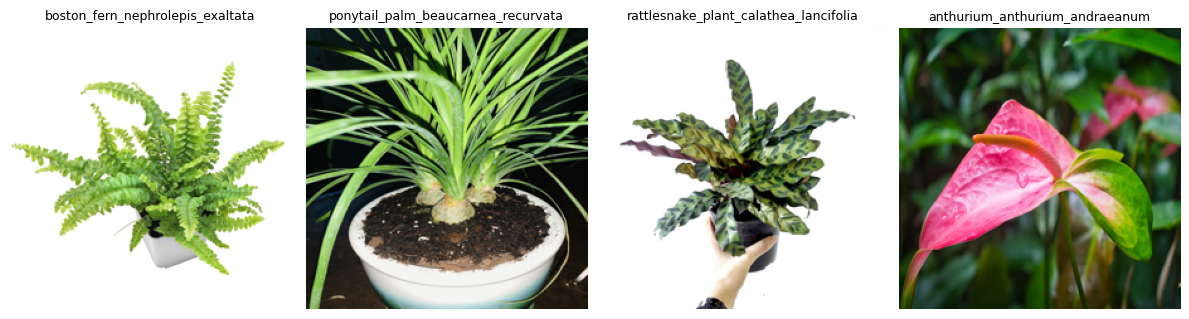

In [6]:
# Cell 6 — Build datasets
train_paths, train_labels = get_paths_and_labels(classes, "train")
val_paths,   val_labels   = get_paths_and_labels(classes, "val")
test_paths,  test_labels  = get_paths_and_labels(classes, "test")
print(len(train_paths), len(val_paths), len(test_paths))

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(4000, reshuffle_each_iteration=True)
    .map(safe_load_and_label, num_parallel_calls=AUTOTUNE)
    .filter(lambda img, lbl: tf.not_equal(lbl, -1))
    .map(tf_augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(safe_load_and_label, num_parallel_calls=AUTOTUNE)
    .filter(lambda img, lbl: tf.not_equal(lbl, -1))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(safe_load_and_label, num_parallel_calls=AUTOTUNE)
    .filter(lambda img, lbl: tf.not_equal(lbl, -1))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Quick visual PIL-only
show_batch_paths(val_paths, n=4)

In [7]:
# Cell 7 — Model: MobileNetV3Small (freeze → fine-tune)
from tensorflow.keras import layers, models

base = tf.keras.applications.MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet"
)
base.trainable = False  # freeze backbone initially

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

4334752/4334752 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 47)                27119     
                                                                

In [8]:
# Cell 8 — Callback: save side-by-side augment each epoch
class SaveAugmentSamples(tf.keras.callbacks.Callback):
    def __init__(self, sample_path, out_dir):
        super().__init__()
        self.sample_path = sample_path
        self.out_dir = Path(out_dir); self.out_dir.mkdir(parents=True, exist_ok=True)
        self.original = Image.open(sample_path).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
    def on_epoch_end(self, epoch, logs=None):
        orig = self.original
        aug  = Image.fromarray(augment_numpy(np.array(orig)))
        orig.save(self.out_dir / f"epoch_{epoch+1:02d}_original.jpg")
        aug.save(self.out_dir / f"epoch_{epoch+1:02d}_augmented.jpg")
        side = Image.new("RGB", (IMG_SIZE*2, IMG_SIZE))
        side.paste(orig, (0,0)); side.paste(aug, (IMG_SIZE,0))
        side.save(self.out_dir / f"epoch_{epoch+1:02d}_side_by_side.jpg")
        print(f"Saved augment samples for epoch {epoch+1}")

sample_image_path = val_paths[0] if len(val_paths)>0 else train_paths[0]
save_aug_cb = SaveAugmentSamples(sample_image_path, augment_samples_dir / "epochs")

In [9]:
# Cell 9 — Train (frozen backbone)
EPOCHS_HEAD = 10
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=[save_aug_cb],
)

best_model_dir = models_dir / "ckpts_v3"
best_model_dir.mkdir(exist_ok=True)
model.save(best_model_dir / "head_trained.keras", include_optimizer=False)

Epoch 1/10
      8/Unknown - 12s 817ms/step - loss: 3.8063 - accuracy: 0.0391

C:\Users\razer\Documents\workspace\AI F.R.I.E.N.D.S\plantenv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


    322/Unknown - 275s 835ms/step - loss: 3.7562 - accuracy: 0.0538Saved augment samples for epoch 1
322/322 [==============================] - 321s 979ms/step - loss: 3.7562 - accuracy: 0.0538 - val_loss: 3.9469 - val_accuracy: 0.0296
Epoch 2/10
322/322 [==============================] - 311s 965ms/step - loss: 3.7302 - accuracy: 0.0599 - val_loss: 3.9300 - val_accuracy: 0.0296
Epoch 3/10
322/322 [==============================] - ETA: 0s - loss: 3.7198 - accuracy: 0.0563

KeyboardInterrupt: 

In [ ]:
# Cell 10 — Fine-tune last layers (unfreeze tail)
for layer in base.layers[:-40]:
    layer.trainable = False
for layer in base.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

EPOCHS_FT = 5
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FT,
    callbacks=[save_aug_cb],
)

model.save(best_model_dir / "finetuned.keras", include_optimizer=False)

In [ ]:
# Cell 11 — Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

In [ ]:
# Cell 12 — Save labels and SavedModel
final_saved = models_dir / "plant_classifier_savedmodel"
model.save(final_saved, include_optimizer=False)
labels_path = models_dir / "labels.txt"
with open(labels_path, "w", encoding="utf-8") as f:
    for cls in classes:
        f.write(cls + "\n")
print("Saved:", final_saved)
print("Labels:", labels_path)

In [ ]:
# Cell 13 — TFLite INT8 conversion (with representative dataset)
def representative_dataset_gen():
    # sample up to 200 training images as calibration set
    import random
    sample = random.sample(train_paths, min(200, len(train_paths)))
    for p in sample:
        try:
            img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
            arr = np.array(img).astype(np.float32)/255.0
            yield [np.expand_dims(arr, 0)]
        except Exception:
            continue

converter = tf.lite.TFLiteConverter.from_saved_model(str(final_saved))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter._experimental_disable_batchmatmul_unfolding = True  # stability tweak

tflite_bytes = converter.convert()
(models_dir / "plant_model_int8.tflite").write_bytes(tflite_bytes)
print("Saved:", models_dir / "plant_model_int8.tflite")

In [ ]:
# Cell 14 — Quick TFLite correctness + speed check (CPU)
interpreter = tf.lite.Interpreter(model_path=str(models_dir / "plant_model_int8.tflite"))
interpreter.allocate_tensors()
inp = interpreter.get_input_details()[0]
out = interpreter.get_output_details()[0]

# pick one validation image
img = Image.open(val_paths[0]).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
x = np.array(img).astype(np.uint8)  # uint8 for INT8 model
x = np.expand_dims(x, 0)

# warmup
for _ in range(5):
    interpreter.set_tensor(inp['index'], x)
    interpreter.invoke()

# timing
import time
N=50; t0=time.time()
for _ in range(N):
    interpreter.set_tensor(inp['index'], x)
    interpreter.invoke()
t1=time.time()
avg_ms = (t1-t0)/N*1000
pred = interpreter.get_tensor(out['index'])[0]
idx = int(np.argmax(pred))
print(f"Avg inference: {avg_ms:.2f} ms | Pred: {classes[idx]}")